## 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch.autograd import Variable

import torchvision
from torchvision import transforms

from PIL import Image
%matplotlib inline

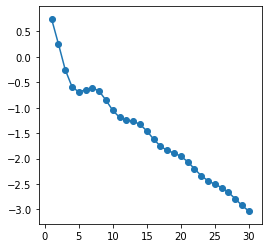

In [2]:
# Генерация графика

def func_y(x):
    return np.sin(x)/x - x/10

x = np.linspace(1, 30, 30)
y = func_y(x)

PATH_TO_IMAGE ='../data/plot/y_plot.png'

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.scatter(x, y)
plt.savefig(PATH_TO_IMAGE)

In [3]:
img = Image.open(PATH_TO_IMAGE)

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

real_imgTensor = data_transforms(img)
real_imgTensor.shape

torch.Size([4, 288, 288])

In [4]:
real_imgTensor = real_imgTensor[:-1]
real_imgTensor.shape

torch.Size([3, 288, 288])

In [5]:
EPOCHS = 200
BATCH_SIZE = 1
LEARNING_RATE = 0.0002

B1 = 0.5
B2 = 0.999

LATENT_DIM = 100

CLASSES = 1
IMG_SIZE = 288
CHANNELS = 3

SAMPLE_INTERVAL = 25

IMG_SHAPE = (3, 288, 288)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(IMG_SHAPE))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *IMG_SHAPE)
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [8]:
generator = Generator()
discriminator = Discriminator()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [9]:
d_loss_history = []
g_loss_history = []

In [10]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(EPOCHS):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

    valid = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0), requires_grad=False)
    
######################  Тренировка генератора    ##########################

    optimizer_G.zero_grad()
    
    # генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))))
    
    # Генерируем даные Генератором на основе шума
    gen_imgs = generator(z)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])

## 2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.